# Analysis of Financial Time Series with Persistent Homology

<hr>
<hr>

## a. Description

This project's goal is to analyze the evolution of daily returns of four key US stock markets indices (i.e. DowJones, Nasdaq, Russell2000, SP500) over the period 1989 – 2016 using persistent homology, following the approach proposed in "[Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf)" by Marian Gidea and Yuri Katz.

A classical approach in Topological Data Analysis (TDA) to extract topological features from multivariate time-series with values in $R^d$ ($d = 4$ here, since we are considering the evolution of four indices) consists in using a sliding window of fixed length $w$ to generate a sequence of $w$ points in $R^d$.

Using the Vietoris-Rips filtration, the persistence diagram of each of these point clouds is then computed and used as a topological feature for further analysis or processing of the initial data. This project aims at reproducing the experiments in the paper cited above and explore and discuss a few variants.


## b. Notebook Steps

<u>**Step 1**</u> -- Perform simple data exploration on the available dataset and note important/applicable points from the provided article (we will specifically pay attention to Sections 3.1 and 4).

<u>**Step 2**</u> -- Write a function to compute persistence landscapes *WITHOUT* using the GUDHI library. This function should take as input a persistence diagram $D$ (in the GUDHI format), a dimension $k$, the endpoints
$x_{min}$, $x_{max}$ of an interval, the number $n$ of nodes of a regular grid on the interval $[x_{min}, x_{max}]$ and a number of landscapes $m$, and should output an $m \times n$ array storing the values of the first $m$ landscapes of the persistence diagram $D$ on the nodes of the grid. Check on some simple examples that your code
is correct.

<u>**Step 3**</u> -- Use the landscape function to run the experiments done in Section 4 of the paper, using windows of length $w = 40$ and $w = 80$ and $w = 120$. Compare your results to the ones provided in the article: are they similar or not?

<u>**Step 4**</u> -- Propose and experiment other methods, than just computing the norm of landscapes and briefly discuss and compare your results to the ones in Section 4 of the paper.

## c. Library Imports

In [121]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## d. Function Declarations

In [165]:
def compute_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given an input standardized stock price dataframe, transforms
    the dataframe in its relative-valued counterpart:
    - prices are transformed into their log-return
    - volume is transformed into a percent change
    """
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    # Computes the log-returns for each price column
    price_columns = ["open", "high", "low", "close", "adj_close"]
    for column in price_columns:
        log_price            = np.log(new_df[column])
        log_price_shifted    = np.log(new_df[column].shift(1))
        new_df[column+"_lr"] = log_price - log_price_shifted
    # Computes the volume percent change
    new_df["volume_pct_change"]=new_df["volume"].pct_change()
    return new_df

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Formats the column names of the dataframe:
    - lower casing
    - space swapped for underscore
    """
    # Declares useful anonymous function
    format_column_name = lambda x: x.lower().replace(" ", "_")
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    new_df.columns = list(map(format_column_name, new_df.columns))
    return new_df

def henon_map(
    a: float, b: float, n: int, x0: float, y0: float
) -> np.array:
    """
    Implements a classic hénon map process.
    """
    hm = [(x0, y0)]
    for step in range(0, n):
        y = hm[-1][0]
        x = 1 - a*y**2 + b*hm[-1][1]
        hm.append((x, y))
    hm = np.array(hm)
    plt.figure(figsize=(12,2))
    plt.plot(hm[:150,0])
    plt.title("Firsts 150 points of the henon map/attractor system")
    plt.show()
    plt.figure(figsize=(12,12))
    plt.scatter(hm[0,0], hm[0,1], c="red")
    plt.scatter(hm[1:,0], hm[1:,1], s=0.5)
    plt.title("Attractor")
    plt.show()
    return hm[:,0]
    
def noisy_henon_map(
    b: float, timestep: float, noise_intensity:float, x0: float, y0: float
) -> np.array:
    """
    Implements the hénon map with noise modification implemented
    in the paper.
    """
    hm = [(x0, y0)]
    As = [0]
    while As[-1]<1.4:
        random_move = np.random.normal(0,1)*np.sqrt(timestep)
        x = 1 - As[-1]*hm[-1][0]**2 + b*hm[-1][1] + \
            noise_intensity*random_move
        y = hm[-1][0] + noise_intensity*random_move
        next_step = As[-1]+timestep if As[-1]+timestep <=1.4 else 1.4
        As.append(next_step)
        hm.append((x, y))
    hm = np.array(hm)
    plt.figure(figsize=(12,2))
    plt.plot(As, hm[:,0])
    plt.title("Henon map/attractor system with Gaussian noise")
    plt.show()
    plt.figure(figsize=(12,12))
    plt.scatter(hm[0,0], hm[0,1], c="red")
    plt.scatter(hm[1:,0], hm[1:,1], s=0.5)
    plt.title("Attractor with Gaussian nosie")
    plt.show()
    return hm[:,0]

def plot_price_data(
    df_list: list,  legend: list, 
    target_column: str, title: str
) -> None:
    """
    Given a list of standardized stock price data, plots the
    Adjusted Close value across the whole available timeline.
    """
    plt.figure()
    # Fixes x-ticks interval to c. a year
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
    for df in df_list:
        plt.plot(df["date"].tolist(), 
                 df[[target_column]],
                 linewidth=.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(legend)
    plt.show()
    
def reverse_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Revert the order of a dataframe.
    """
    # Copies the input dataframe and updates the column names
    new_df = df.copy()[::-1]
    new_df.index = range(0, len(df))
    return new_df

def white_noise_with_gamma_inverse_var():
    """
    Implements the white noise with gamma-distributed inverse
    variance generation implemented in the paper.
    """
    # Declares the gamma distribution parameters
    alpha = 8
    beta = 1
    simulation = None
    # Performs 100 realization of a 4D 100-point cloud dataset
    for realization in range(100):
        # Updates alpha parameter if need be
        if realization > 75:
            alpha -= 0.25
        gamma_variance = np.random.gamma(shape = beta, scale = alpha)
        cloud_set = np.random.normal(0, 1/np.sqrt(gamma_variance),
                                     (4, 100))
        if simulation is None:
            simulation = cloud_set
        else:
            simulation = np.concatenate([simulation, cloud_set], axis=1)
    return simulation

def white_noise_with_growing_var(n_realization: int) -> dict:
    """
    Implements the white noise with growing variance generation 
    implemented in the paper.
    """
    simulations = {}
    # base variance is grown from 1 to 10, i.e. 10 simulations
    for var in range(1, 11):
        full_simulation = None
        # n realization of 4 time series are performed per
        # simulations
        for n in range(n_realization):
            ts_simulation = None
            for time_series in range(4):
                update_var = var + np.random.uniform(-0.1, 0.1)
                realization = np.random.normal(0, update_var, (1, 100))
                if ts_simulation is None:
                    ts_simulation = realization
                else:
                    ts_simulation = np.concatenate([ts_simulation,
                                                    realization])
            if full_simulation is None:
                full_simulation = ts_simulation
            else:
                full_simulation = np.concatenate([full_simulation,
                                                  ts_simulation], axis=1)
        simulations[var] = full_simulation.reshape(4, -1)
    return simulations

<hr>
<hr>

# 1. Step 1 - Paper Summary and Data Pre-processing/Exploration

### 1.1 Notes on the paper

<u>***The paper's motivation(s)***:</u>

Sharp changes in the behavior of financial markets produce deep social, political and economic impacts, destabilizing economies, nations and people's lives at a systemic level (e.g. 2000-2001 Dotcom Bubble, 2008 Financial Crisis, 2012 Euro Debt Crisis, etc.). Predicting such changes corresponds to a large area of research in the field of econometrics (e.g. the development of the co-value-at-risk, or CoVaR, by Tobias Adrian and Markus Brunnermeier in the [paper of the same name](https://www.aeaweb.org/articles?id=10.1257/aer.20120555), American Economic Review, Vol.106, No.7, July 2016) which has a strong influence on policymaking worldwide.

The paper at hand, "[Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf)" by Marian Gidea and Yuri Katz, proposes the use of persistence homology to highlight such sharp changes in financial markets -- with predictive capacity. Furthermore, since financial markets are complex systems that are hard to model, topological data analysis can help analyze the data as it does not require any information about the underlying stochastic process.

<u>***The paper's input data and its formatting***:</u>

The paper analyses a 4-dimensional time series of daily log-returns obtained by pre-processing the daily adjusted closing pricese of 4 key stock market indexes: S&P500, Dow Jones, NASDAQ, Russel 2000 (See Section 1.3 for more information on log-returns).

The paper is looking to transform this pre-processed financial market data into a topological embedding (persistence landscapes) useful for perform statistical treatment and analysis (the computation of $L^p$ norms). 

As such, the paper's TDA application aims at:

> **<span style="color:green">Computing topological times series constructed with the $L^1$ and $L^2$ norms of the persistence landscape (obtained via Vietoris-Rips filtration and persistence diagrams) of window slices of the original stock market log-return time series.</span>**


<u>***The paper's proposed workflow***:</u>

The paper proposes a topological analytic framework to study financial market behaviors which relies on the following workflow:

0. **From price to log-return**

The paper exports Yahoo Finance price data of the 4 target stock market indexes and pre-process them into a 4D matrix of log-return (See Section 1.3).

1. **Choice of preliminary TDA parameters**

The first step of the process is the selection of a few key parameters for the whole process:
    - sliding/scaling window $w$
    - range of $\epsilon$ radii
    - $p$ parameter(s) of the norm(s) $L^p$
    
> <span style="color:green">Application to the data</span>:
>
> The paper considers two window sizes $w\in\{50, 100\}$. 
    
2. **Extraction of time-dependent point cloud data sets**

The paper defines a point cloud data set $X_i$ as a $w\times d$ matrix where each of the $d$ columns corresponds to a slide of an original 1D time series and $w$ the time-window used to compute the slice. A set of point cloud data set $X_i$ is called "time-ordered sequence of point clouds".

\begin{align}
\text{Given } d, n, w &\in \mathbb{N}_+\\
\epsilon&\in\mathbb{R}_+\\
\forall i\in\{1,\ldots,n\},x_i&\in\mathbb{R}^d\\
\text{Given the point cloud }X_i&\in\mathbb{R}^{d\times w}\\
&=\{x_i, \ldots, x_{i+w}\}\\
\end{align}

> <span style="color:green">Application to the data</span>:
>
> The 4D time-series matrix is split into subsets (point cloud data sets) of size $w\times d$ with a time step of 1, resulting in $n-w$ matrices.

3. **Measuring topological persistence (i.e. persistent homology)**

Given a range of radii $\epsilon>0$, a Vietoris-Rips complex $R(X, \epsilon)$ is constructed at each $\epsilon$-resolution for each point cloud $X$. $\forall k\in\{0,1,2,\ldots\}$, a $k$-simplex of vertices $\{X_{i1}, \ldots,x_{ik}\}$ is part of $R(X, \epsilon)$ if and only if the mutual distance between any pair of vertices is less than $\epsilon$ such that for some distance $d$: $d(x_{ij}, x_{il})<\epsilon$.

These complexes $R(X, \epsilon)$ form a filtration. From each complexes, one can compute $k$-dimensional homology classes part of the homology group $H_k(R(X, \epsilon))$ such that:

\begin{align}
\forall \epsilon>0\\
\text{Given }\epsilon_1<\epsilon_2\\
R(X, \epsilon_1)&\subseteq R(X, \epsilon_2)\\
H_k(R(X, \epsilon_1))&\subseteq H_k(R(X, \epsilon_2))\\
\end{align}

For instance, a class in the 1-dimensional homology group $H_1(R(X, \epsilon))$ corresponds to an independent loop in $R(X, \epsilon)$.

Each homology class $\alpha$ is characterized by a point $z_\alpha=(b_\alpha, d_\alpha)$ and multiplicity $\mu_\alpha(b_\alpha, d_\alpha)$ where $b_\alpha$ and $d_\alpha$ are respectively called "birth" and "death" values such that:

\begin{align}
b_\alpha&=\epsilon_1\\
d_\alpha&=\epsilon_2\\
\epsilon_1&<\epsilon_2\\
\text{such that }\alpha&\in H_k(R(X, \epsilon_1))&\text{ s.t. } \forall\delta>0,\,\,\alpha\not\in H_k(R(X, \epsilon_1-\delta))\\
\alpha&\not\in H_k(R(X, \epsilon_2))&\text{ s.t. } \forall\text{ small enough }\delta,\,\,\alpha\in H_k(R(X, \epsilon_2-\delta))\\
&\mu_\alpha(b_\alpha, d_\alpha)&\text{the number  of classes $\alpha$ born at $b_\alpha$and dead at $d_\alpha$}
\end{align}

> <span style="color:green">Application to the data</span>:
>
> A Vietoris-Rips complex filtration is computed on each of the $n-w$ matrices.

4. **Encoding in a persistence diagram**

For each $k$-dimensional homology class $\alpha$, one can construct a persistence diagram $P_k$ by projecting:
- The points $z_\alpha$ of the homology group $H_k(R(X, \epsilon))$ on a 2D plot
- The points $\{(x, y)|x=y\}$ (i.e. the diagonal) on the same 2D plot, representing the classes instantly born and dying at each level $\epsilon$

The x-axis of the diagram represents the birth index of a class $\alpha$ and the y-axis the death index of the same class $\alpha$. 

![vr_complexes](data/vr_complexes.png)

![persistence_diagram](data/persistence_d.png)
<center><i>Rips filtration of simplicial complexes illustrating the birth</i></center>
<center><i>and death of loops along with the 1-dimensional persistence diagram (extracted from the paper)</i></center>

> <span style="color:green">Application to the data</span>:
>
> A persistence diagram is computed for each of the $n-w$ matrices from each corresponding Vietoris-Rips complex filtration.
>
> Of note, the paper focuses on 1-dimensional homology only from then on ("persistence homology of loops," p3; "In the sequel, we will use only the 1-dimensional homology," p5).

5. **Encoding in a persistence landscape**

The metric space of persistence diagrams $(\mathcal{P}, W_P)$ (with the Wasserstein distance) does not lend itself as-is to time-series analysis -- the goal of the paper. As such, the paper proposes to embed the space of persistent diagrams constructed from the underlying financial data into a space of persistence landscapes.

The persistence landscape of a persistence diagram $P_k$ is the sequence of functions $\lambda_l(x)$ constructed such that:

\begin{align}
\forall k&\in\{0, 1, 2,\ldots\}\\
\forall (b_\alpha, d_\alpha) &\in P_k\\
f_{(b_\alpha, d_\alpha)} &=
    \begin{cases}
      x-b_\alpha & \text{if } x\in(b_\alpha, \frac{b_\alpha+d_\alpha}{2}]\\
      -x+d_\alpha & \text{if } x\in(\frac{b_\alpha+d_\alpha}{2}, d_\alpha)\\
      0 & \text{otherwise}
    \end{cases}\\
\forall l\in\mathbb{N}_+,\,\,\lambda_l(x) &: \mathbb{R}\rightarrow[0,1]\\
&= 
    \begin{cases}
        l\text{-max}\{f_{(b_\alpha, d_\alpha)}(x)|(b_\alpha, d_\alpha)\in P_k\}&\text{if the $l$-th largest value of the function $f_{(b_\alpha, d_\alpha)}$ exists}\\
        0 &\text{otherwise}
    \end{cases}\\
\end{align}

> <u>Note on Banach spaces in $\{\mathbb{R},\mathbb{C}\}$:</u>
> 
> Given $\mathbb{F}\in\{\mathbb{R},\mathbb{C}\}$, we define $X$ as a $\mathbb{F}$-vector space.
> We also define a map $||.||:X\rightarrow[0,+\infty)$ called a norm such that:
>
> - $\forall x \in X,\,\,||x||=0\Leftrightarrow x=0$ (positive definiteness)
> 
> - $\forall \nu\in\mathbb{F},\,\,x\in X,\,\,||\nu.x|| = |\nu|.||x||$ (absolute homogeneity)
>
> - $\forall x, y\in X,\,\,||x+y|| \le ||x|| + ||y||$ (triangular inequality)
>
> The space $X$ equipped with the norm $||.||$ and denoted $(X, ||.||)$ is called a normed space. 
>
> If ||.|| is a norm for the $\mathbb{F}$-vector space $X$, then $\forall x, y\in X,\,\,d_{||.||}(x, y)= ||x-y||$ defines a metric for the set $X$.
>
> If the object $(X, d_{||.||})$ is a complete metric space, then the normed space $(X, ||.||)$ is a Banach space. 
>
> A complete metric space is a metric space where every Cauchy sequence (i.e. a sequence $(x_n)\in X$ such that for any $\epsilon>0,\,\,\exists n_\epsilon\in\mathbb{N}$ s.t. $d(x_m,x_n)<\epsilon$, for any $m\ge n_\epsilon, n\ge n_\epsilon$) in $X$ converges to a point in $X$.
>
> <u>Expansion to the sequence of functions $\lambda_l(x)$:</u>
>
> This definition can be expanded to the sequence of functions $\forall l\in\mathbb{N}_+,\,\,\lambda_l(x):\mathbb{R}\rightarrow\mathbb{R}$ as  it displays, as per the paper, an obvious vector structure such that:
>
> Given sequences of functions $\forall x\in\mathbb{R},\, k\in\mathbb{N}_+,\,\eta=(\eta_k)_{k\ge0},\,\,(\eta^1 + \eta^2)_k(x) = \eta^1_k(x) + \eta^2_k(x)\text{ and }(c.\eta)_k(x) = c.\eta_k(x)$
>
> this structure can be expanded with a norm such that:
>
> $$L^p\text{-norm of }\eta=||\eta||_p=\big(\underset{i=1}{\overset{\infty}{\sum}}||\eta_k||^p_p\big)^{\frac{1}{p}}$$
> 
> **source**: [Functional Analysis - Part 6 - Norms and Banach spaces](https://www.youtube.com/watch?v=imYQJOgUx7Y)

![persistence_diagram](data/persistence_l.png)
<center><i>Corresponding persistence landscape of the persistence diagram above</i></center>
<center><i>(extracted from the paper)</i></center>

> <span style="color:green">Application to the data</span>:
>
> A persistence landscape is computed from each corresponding persistence diagram.

6. **Computing of $L^p$ norm times series**

Given the properties of the persistence landscape as Banach spaces as highlighted above, a $L^p$ norm can be computed for each obtained persistence landscape (one per window), producing a time series of $L^p$ norms (which the paper normalizes).

> <span style="color:green">Application to the data</span>: 
>
> A $L^1$ and $L^2$ norm is computed from each corresponding persistence landscape (the paper restricted the computation of the $L^p$ norm to $p\in\{1, 2\}$.

7. **Visualization of potential trends with further statistics**

<span style="color:red">500/250 days window variance spectral density (Average at low frequencies), 250 days auto-correlation function (ACF), Mann-Kendal test monotonic upward or downward movement of the variable over time</span>

<u>***The paper's note on Time-Delay Embedding***:</u>

The paper clarifies that the method differs highly from an ubiquitous and at-first-glance similar-looking TDA method applied to time series called "time-delay embedding". Where time delay embedding requires two parameters (sliding window and segment sizes), the paper's method only requires one parameter (a sliding window size).

Furthermore, the paper's method circumvents the issue of the time-delay embedding methods by not embedding the original data in a high-dimensional space, prefering to represent a times series in a low dimensional space and computing a norm in $\mathbb{R}$ per obtained segment.

<u>***Experimentation on synthetic data***:</u>

To experiment with the new persistence-landscape method, the paper tests it on three types of synthetically generated data. 

1. **Chaotic time series with noise -- Hénon map**:

Hénon maps is a 2D analogue to logistic maps used to model economic cycles. The Hénon map is defined by:

\begin{align}
x_{n+1} &= 1 - ax^2_n + by_n\\
y_{n+1} &= x_{n+1}
\end{align}

To the classic Hénon map setup, the paper adds a Gaussian noise and a timestep update of the parameter $a$ (growing from 0 to 1.4 by timestep) such that:

\begin{align}
a_0 &= 0\\
\sigma &>0\\
W_n &\sim \mathcal{N}(0, 1)\\
x_{n+1} &= 1 - a_nx^2_n + by_n + \sigma W_n\sqrt{\Delta t}\\
y_{n+1} &= x_{n+1} + \sigma W_n\sqrt{\Delta t}\\
a_{n+1} &= a_n + \sqrt{\Delta t}
\end{align}

> <span style="color:green">Use in the paper</span>: 
>
> To emulate the originally selected 4 stock index time series (extracted from Yahoo Finance), the paper synthesizes 4 time series via the use of noisy Hénon maps with fixed parameters $b\in\{0,27, 0.28, 0.29, 0.3\}$, a $0.001$ timestep, a noise intensity of $1$, and a standard normal Gaussian random variable $W$ (the last three parameters are inferred as they are not listed in the paper).
>
> The paper uses those 4 synthesized time series in order to test their new TDA methodology and point out that using persistence landscape can capture change in regime of a stochastic process

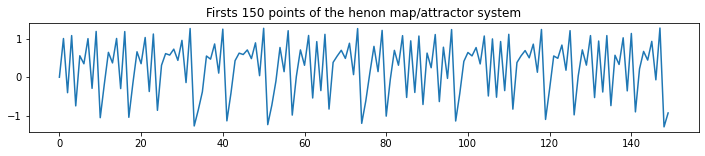

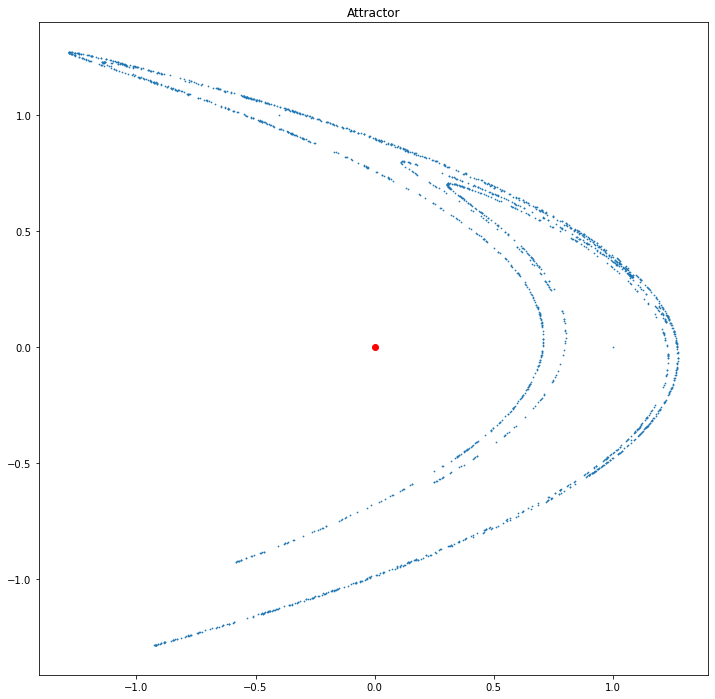

In [123]:
# classic henon attractor
_ = henon_map(a=1.4, b=.3, n=2000, x0=0, y0=0)

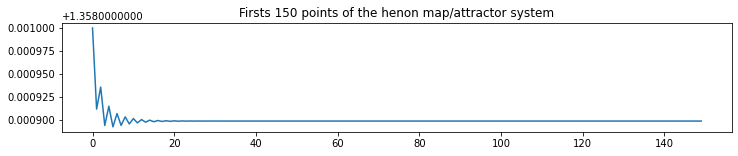

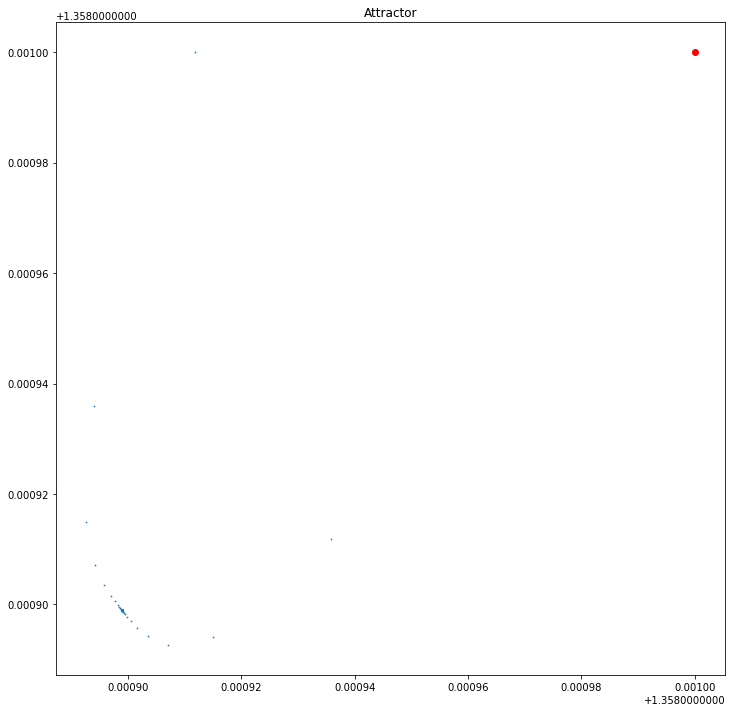

In [124]:
# Converging henon map
_ = henon_map(a=.1, b=.4, n=150, x0=1.359, y0=1.359)

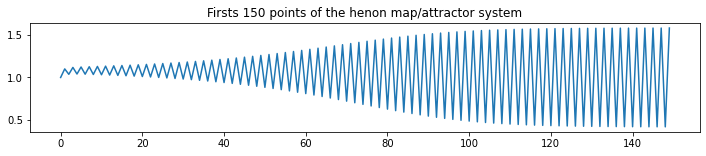

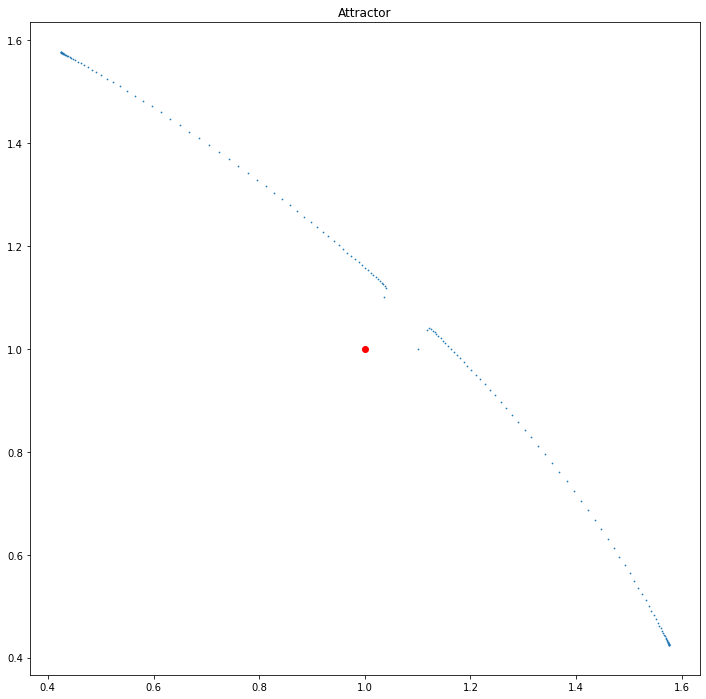

In [125]:
# Non converging henon map
_ = henon_map(a=.3, b=.4, n=150, x0=1, y0=1)

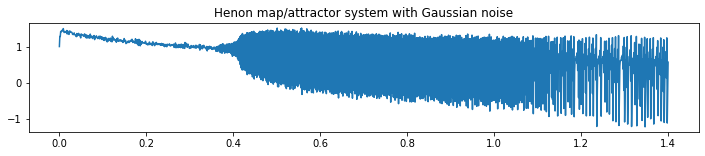

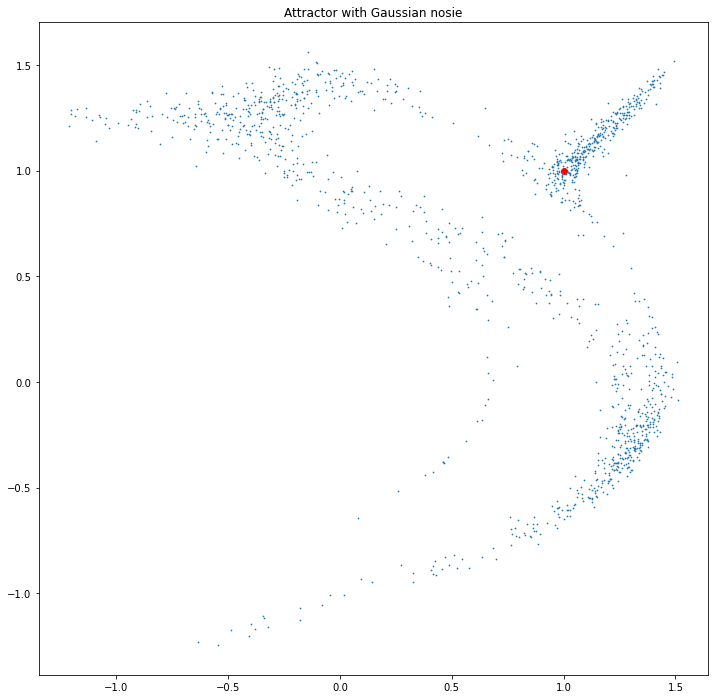

In [126]:
# Reproduces in the first plot the graph available in Figure 2
# May need to be run more than once because of an overflow risk
_ = noisy_henon_map(b=0.3, timestep=0.001, noise_intensity=1, x0=1, y0=1)

2. **White noises with growing variance**:

White noise with growing variance corresponds to a simulation of $L^p$ norms via Monte Carlo simulations.

> <u>Number of simulations:</u> 10 such that $\sigma \in \{1, 2,\ldots, 10\}$
> 
> The below procedure is repeated for as many times as needed:
> - Generate 4 time series of 100 data points s.t. (this 400-point cloud data set is called a "realization" $X_i$)
\begin{align}
\forall i &\in \{1, 2, 3, 4\}\\
\forall j &\in \{1, 2, \ldots, 100\}\\
\delta_i&\sim \text{Unif}[-0.1, 0.1]\\
\forall x_{i,j}\in X_{i}, x_{i,j}&\sim \mathcal{N}(0, (\sigma+\delta_i)^2)\\
\end{align}
> - Perform the paper's workflow on the realization and yield the corresponding $L^1$ and $L^2$ norms
> - Collect the $L^1$ and $L^2$ norms per realization and compute their mean-value

When graphed, this results in a display of the behavior of the $L^1$ and $L^2$ norms in an increasingly noisy environment.

> <span style="color:green">Use in the paper</span>: 
>
> White noise with a growing variance is used in the paper to test the impact of growing noise on the paper's methods, and especially the resulting $L^p$ norms, showing that these norms are linearly increasing functions of the average variance $\sigma^2$ of the data.

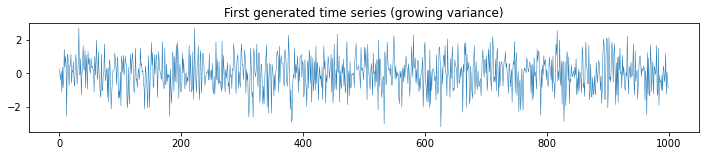

In [171]:
white_noise = white_noise_with_growing_var(10)[1][0, :]
plt.figure(figsize=(12, 2))
plt.plot(white_noise, linewidth=0.5)
plt.title("First generated time series (growing variance)")
plt.show()

3. **White noises with Gamma-distributed inverse variance**:

Due to the observation that stock returns usually display fat tails, the use of Gaussian distributions usually fails to properly model stock returns. As such, the use of "superstatistics" are prefered where an underlying time-series generation probability distribution has its parameters themselves following a probability distribution.

In this case, a normal distribution which variance is determined by an inverse gamma distribution is able to approximate a stock market return time series $X$ such that:

\begin{align}
\forall x\in X, x&\sim\mathcal{N}(0, \frac{1}{\sqrt{\gamma}})\\
\gamma &\sim \Gamma(\alpha, \beta) \\
f_{\Gamma(\alpha, \beta)}(\gamma, \alpha, \beta) &= \frac{\beta^\alpha}{\Gamma(\alpha)}\gamma^{\alpha-1}exp(-\beta\gamma),\,\,\gamma\ge0,\alpha, \beta>0
\end{align}

> The following procedure is repeated 100 times (producing 100-point cloud data set of 100 data points each):
> - Generate a 4D time series of 100 data points s.t. (this cloud data set is called a "realization" $X_i$)
\begin{align}
\forall i &\in \{1, 2, 3, 4\}\\
\forall j &\in \{1, 2, \ldots, 100\}\\
\gamma_i&\sim \Gamma(\alpha, \beta)\\
\beta &= 1\\
\alpha &= 8 \text{ for the first 75 realizations, then decreases by 0.25-step}\\
\forall x_{i,j}\in X_{i}, x_{i,j}&\sim \mathcal{N}(0, \frac{1}{\sqrt{\gamma}})\\
\end{align}
> - Perform the paper's workflow on the realization and yield the corresponding $L^1$ and $L^2$ norms
> - Collect the $L^1$ and $L^2$ norms per realization and compute their mean-value

When graphed, this results in a display of the behavior of the $L^1$ and $L^2$ norms which higlights change in regime from a "regular" (low variance) to a "heated" (high variance) regime.

> <span style="color:green">Use in the paper</span>: 
>
> White noise with Gamma-distributed inverse variance is used in the paper to test change in regimes in the underlying data via the use of $L^p$ norms, showing that these norms are sensitive to such changes and valuable in the case of financial markets where such changes can occur.

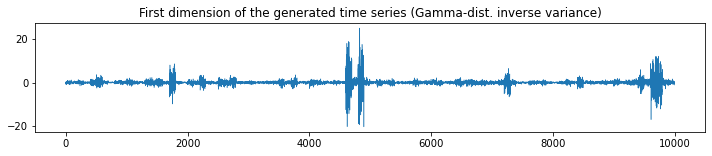

In [170]:
white_noise = white_noise_with_gamma_inverse_var()[0, :]
plt.figure(figsize=(12, 2))
plt.plot(white_noise, linewidth=0.5)
plt.title("First dimension of the generated time series (Gamma-dist. inverse variance)")
plt.show()

<u>***Results on the real Stock Market data***:</u>




### 1.2 Data exploration

<u>Importing the four stock index .csv files:</u>

In [7]:
# Sets path and file names
dpath = "data/"
files = ["dowjones.csv", "nasdaq.csv", "russel2000.csv", "sp500.csv"]

# Imports
dowjones   = format_dataframe(pd.read_csv(dpath+files[0]))
nasdaq     = format_dataframe(pd.read_csv(dpath+files[1]))
russel2000 = format_dataframe(pd.read_csv(dpath+files[2]))
sp500      = format_dataframe(pd.read_csv(dpath+files[3]))

<u>Reversing the datasets:</u>

We remark that the four datasets are sorted from the most recent to the oldest entry. We invert this order.

In [8]:
dowjones   = reverse_dataframe(dowjones)
nasdaq     = reverse_dataframe(nasdaq)
russel2000 = reverse_dataframe(russel2000)
sp500      = reverse_dataframe(sp500)

<u>Describing the four stock index datasets:</u>

In [9]:
dowjones.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,9105.862283,9164.009674,9046.451886,9108.768028,1.327529e+08,9108.768028
std,4591.493765,4612.191784,4569.933694,4592.338602,1.080034e+08,4592.338602
min,1892.410034,1903.349976,1845.989990,1879.140015,5.170000e+06,1879.140015
25%,4035.600098,4054.629883,4025.580078,4038.370117,3.070000e+07,4038.370117
50%,9961.139648,10036.940430,9875.129883,9961.919922,1.048900e+08,9961.919922
75%,11872.070312,11968.179688,11803.040039,11871.839844,2.139300e+08,11871.839844
max,19559.939453,19664.970703,19527.830078,19614.810547,7.384400e+08,19614.810547


In [10]:
nasdaq.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,2046.851121,2061.155424,2030.069391,2046.431813,1.272756e+09,2046.431813
std,1308.226234,1316.374729,1298.087048,1307.761834,8.269404e+08,1307.761834
min,325.100006,325.700012,323.000000,325.399994,4.421000e+07,325.399994
25%,804.460022,808.690002,804.460022,807.380005,3.488100e+08,807.380005
50%,1957.260010,1972.310059,1939.560059,1959.239990,1.545720e+09,1959.239990
75%,2658.530029,2675.209961,2637.659912,2657.219971,1.922070e+09,2657.219971
max,5394.149902,5425.520020,5389.100098,5417.359863,4.553600e+09,5417.359863


In [11]:
russel2000.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,541.634331,545.258122,537.669418,541.784923,1.903291e+07,541.784923
std,310.343577,312.363606,308.122820,310.423800,1.785974e+07,310.423800
min,118.309998,118.959999,118.019997,118.300003,5.720000e+05,118.300003
25%,264.049988,265.029999,263.179993,264.140015,3.225700e+06,264.140015
50%,480.959991,484.850006,475.980011,481.130005,1.283300e+07,481.130005
75%,736.500000,742.190002,729.750000,736.590027,3.336120e+07,736.590027
max,1364.430054,1386.449951,1363.699951,1386.369995,1.145623e+08,1386.369995


In [12]:
sp500.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,1048.014023,1054.464612,1041.154037,1048.282910,1.904413e+09,1048.282910
std,515.875484,518.431655,513.113535,515.946592,1.784001e+09,515.946592
min,242.649994,244.250000,240.169998,242.630005,1.499000e+07,242.630005
25%,490.049988,492.890015,490.049988,491.880005,3.247100e+08,491.880005
50%,1111.469971,1118.739990,1105.270020,1111.089966,1.286300e+09,1111.089966
75%,1358.849976,1367.410034,1348.030029,1359.880005,3.335710e+09,1359.880005
max,2241.129883,2251.689941,2237.570068,2246.189941,1.145623e+10,2246.189941


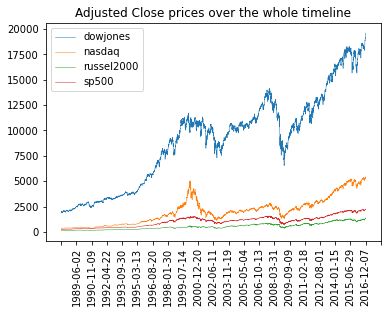

In [13]:
legend = ["dowjones", "nasdaq", "russel2000", "sp500"]

plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "adj_close",
                "Adjusted Close prices over the whole timeline")

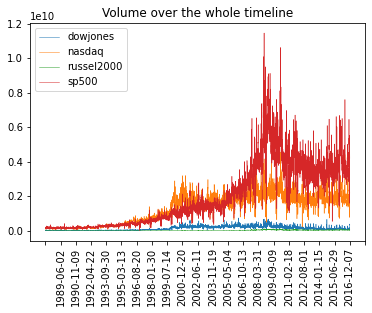

In [14]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "volume",
                "Volume over the whole timeline")

### 1.3 Computing log-returns and volume percent changes

The logarithm of returns is an ubiquitous quantitative finance transformation of time series (and especially price) data. 

> Given a price time series $P$ of length $n\in\mathbb{N}_+$ with components $p_i\,\,\forall i\in\{0,\ldots,n\}$.
>
> $P$ can be transformed into a times series $R$ of returns $r_i\,\,\forall i\in\{1,\ldots,n\}$ such that:

\begin{align}
\forall i\in\{1,\ldots,n\},\,r_i &= \frac{p_i-p_{i-1}}{p_{i-1}}
\end{align}

The main benefit of using relative metrics like returns compared to absolute metrics like prices is normalization, a requirement for many multidimensional statistical analysis setups. However, it is more common to encounter logarithmic returns due to several valuable properties.

\begin{align}
\forall i\in\{1,\ldots,n\},\,r_i &= log(p_i)-log(p_{i-1})
\end{align}

<u>Properties of log-returns:</u>

1. **Log-normality**: Prices are usually assumed to be log-normally distributed in finance.

2. **Approximate raw-log equality**: Given $r^{\text{absolute}}_i$ the return at timestep $i$ of a price time series $P$, and $r_i^{\text{log}}$ the corresponding log-return, we find the following approximation when $r^{\text{absolute}}_i<<1$:

$$\forall i\in\{1,\ldots,n\},\,r^{\text{absolute}}_i\approx log(1+r^{\text{absolute}}_i) = r_i^{\text{log}}$$

3. **Time additivity**: Given an ordered sequence of $n$ prices $p$, the corresponding compounding return $r$ corresponds to the product:

$$1+r=\underset{i=1}{\overset{n}{\Pi}}(1+r_i)$$

This formula is not computationally efficient and, given the product of normally distributed variables are not normally distributed, we would prefer additions. Using the properties of the logarithms, we can rewrite:

$$log(1+r)=\underset{i=1}{\overset{n}{\sum}}log(1+r_i)$$

4. **Numerical stability**: Multiplication of small numbers can lead to airthmetic underflow compared to additions. 

*Source:* [quantivity, feb, 2011](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)

<u>Computing log returns:</u>

Given those properties, we are interested in computing the log returns of each type of price data available to us: Open, Close, High, Low, and Adj. Close.

In [15]:
dowjones   = compute_log_returns(dowjones)
nasdaq     = compute_log_returns(nasdaq)
russel2000 = compute_log_returns(russel2000)
sp500      = compute_log_returns(sp500)

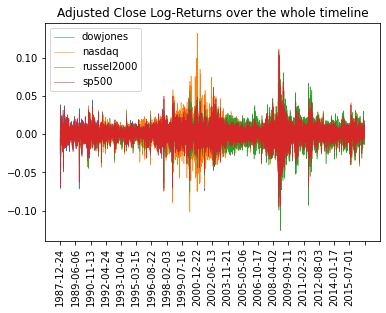

In [16]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "adj_close_lr",
                "Adjusted Close Log-Returns over the whole timeline")

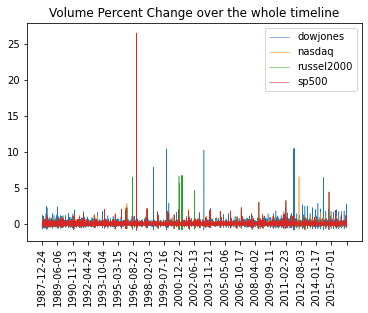

In [17]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "volume_pct_change",
                "Volume Percent Change over the whole timeline")

# 2. Step 2 - Persistence Landscape From Scratch

![persistence_landscape_algo](data/persistence_landscape_algo.png)

[Peter Bubenik, Dlotko Pawel. A persistence landscapes toolbox for topological statistics. Journal of
Symbolic Computation, Elsevier, 2016](https://hal.inria.fr/hal-01258875/file/PersistenceLandscapes_arxiv_v3.pdf)

In [18]:
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import gudhi.representations
%matplotlib inline

In [19]:
dowjones

,date,open,high,low,close,volume,adj_close,open_lr,high_lr,low_lr,close_lr,adj_close_lr,volume_pct_change
0,1987-12-23,1990.219971,2019.560059,1977.619995,2005.640015,22830000,2005.640015,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-12-24,2003.810059,2013.099976,1985.739990,1999.670044,8080000,1999.670044,0.006805,-0.003204,0.004098,-0.002981,-0.002981,-0.646080
2,1987-12-28,1955.569946,1966.180054,1921.920044,1942.969971,13870000,1942.969971,-0.024369,-0.023583,-0.032667,-0.028764,-0.028764,0.716584
3,1987-12-29,1942.810059,1951.760010,1918.099976,1926.890015,9940000,1926.890015,-0.006546,-0.007361,-0.001990,-0.008310,-0.008310,-0.283345
4,1987-12-30,1935.339966,1966.180054,1925.729980,1950.099976,15120000,1950.099976,-0.003852,0.007361,0.003970,0.011973,0.011973,0.521127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7296,2016-12-02,19161.250000,19196.140625,19141.179688,19170.419922,84920000,19170.419922,0.000629,-0.000946,0.000125,-0.001121,-0.001121,-0.219485
7297,2016-12-05,19244.349609,19274.849609,19186.730469,19216.240234,317800000,19216.240234,0.004327,0.004092,0.002377,0.002387,0.002387,2.742346
7298,2016-12-06,19219.910156,19255.890625,19184.740234,19251.779297,284960000,19251.779297,-0.001271,-0.000984,-0.000104,0.001848,0.001848,-0.103335
7299,2016-12-07,19241.990234,19558.419922,19229.830078,19549.619141,385200000,19549.619141,0.001148,0.015589,0.002348,0.015352,0.015352,0.351769


In [20]:
dowjones[["adj_close_lr","high_lr","low_lr"]][5400:5528].to_numpy().shape

(128, 3)

In [21]:
skeleton = gd.RipsComplex(
    points = dowjones[["adj_close_lr","close_lr","open_lr"]][5400:5528].to_numpy(), 
    max_edge_length = 1
)

In [22]:
Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension = 3)
BarCodes = Rips_simplex_tree.persistence()

In [23]:
Rips_simplex_tree.num_vertices()

128

In [24]:
Rips_simplex_tree.num_simplices()

11017632

In [25]:
rips_generator = Rips_simplex_tree.get_filtration()

In [26]:
for i in range(20):
    print(BarCodes[i])

(1, (0.003317319285439587, 0.007482945182624994))
(1, (0.011209068200103091, 0.013674129484088957))
(1, (0.016056068172508143, 0.018186831616014025))
(1, (0.010086040496071829, 0.012167564790576138))
(1, (0.003845674455805558, 0.00575627510191722))
(1, (0.010404353371597373, 0.012243503112573153))
(1, (0.0027527769761069073, 0.004471462313857862))
(1, (0.004486969134509717, 0.005615051482395606))
(1, (0.0072760711280900016, 0.008244840823586045))
(1, (0.006027661591562886, 0.0069836935359010865))
(1, (0.007538949664706703, 0.008295984661974403))
(1, (0.005416088635438084, 0.006128646587157699))
(1, (0.014151934961956165, 0.014824015410729103))
(1, (0.008380560604040892, 0.008945148069133673))
(1, (0.005820887101977902, 0.006102273326642217))
(1, (0.003539129060761525, 0.0038098865332369778))
(1, (0.007716432288794749, 0.007981949568718073))
(1, (0.0038396999530955463, 0.004090815437537062))
(1, (0.005695186971856675, 0.005930351356230542))
(1, (0.004629986230566987, 0.00483203161470330

In [27]:
Rips_simplex_tree.persistence_intervals_in_dimension(1)

array([[0.00339624, 0.00350298],
       [0.00337295, 0.00354199],
       [0.00353913, 0.00380989],
       [0.00406309, 0.00408692],
       [0.0038397 , 0.00409082],
       [0.00275278, 0.00447146],
       [0.00462999, 0.00483203],
       [0.00497364, 0.0050258 ],
       [0.00448697, 0.00561505],
       [0.00384567, 0.00575628],
       [0.00569519, 0.00593035],
       [0.00582089, 0.00610227],
       [0.00541609, 0.00612865],
       [0.00602766, 0.00698369],
       [0.00331732, 0.00748295],
       [0.00771643, 0.00798195],
       [0.00727607, 0.00824484],
       [0.00753895, 0.00829598],
       [0.00838056, 0.00894515],
       [0.01037809, 0.01046266],
       [0.01008604, 0.01216756],
       [0.01040435, 0.0122435 ],
       [0.01120907, 0.01367413],
       [0.01415193, 0.01482402],
       [0.01605607, 0.01818683]])

In [28]:
Rips_simplex_tree.betti_numbers()

[1, 0, 0]

usetex mode requires TeX.


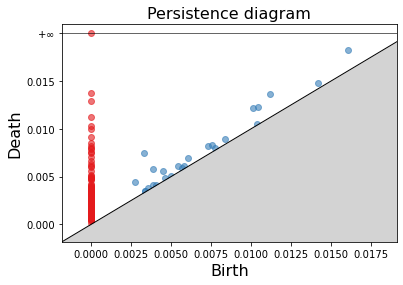

In [29]:
gd.plot_persistence_diagram(BarCodes);

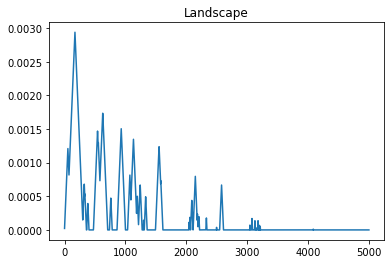

In [30]:
LS = gd.representations.Landscape(resolution=1000)
L = LS.fit_transform([Rips_simplex_tree.persistence_intervals_in_dimension(1)])

plt.plot(L[0])
plt.title("Landscape")
plt.show()

In [31]:
np.linalg.norm(L[0])

0.0373173880299284

In [32]:
L.shape

(1, 5000)

# 3. Step 3 - Reproducing the Paper's Empirical Analysis

# 4. Step 4 - Exploring Further Avenues